# call the libraries

In [1]:
from pyspark.sql import SparkSession
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import io
import numpy as np
import os
from pyspark.sql.functions import udf, col
from pyspark.sql.types import *
import scipy.stats as stats
import numpy as np
from sklearn.ensemble import IsolationForest
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pickle

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
import numpy as np

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go



import numpy as np
import plotly
init_notebook_mode(connected=True)
%matplotlib inline




# initialize spark and spark context

In [3]:
spark = SparkSession.builder.appName('demo-anomaly-profile-dome9-ip-sklearn-oneclasssvm-batch-score').getOrCreate()
sc = spark.sparkContext
sc.version

'2.1.1'

# lets load the Profile data for DOME9 with 3 attributes

In [11]:
data_source = "dome9"
tenant_name = "demo"
time_window="day"
entity_type="ip"
anomaly_type="profile"
model_type="sklearn"
model_name="oneclasssvm"

BASE_PATH = "/Users/tuhinsharma/Documents/sstech/"+tenant_name
ANOMALY_DATA_REPOSITORY = BASE_PATH + "/models_data/data"

USER_PROFILE_DATA_PATH = ANOMALY_DATA_REPOSITORY + "/{data_source}/{entity_type}/{anomaly_type}/{time_window}.json"
data_path = USER_PROFILE_DATA_PATH.format\
                                           (data_source=data_source,\
                                            entity_type=entity_type,anomaly_type="profile",time_window=time_window)
    
ANOMALY_MODEL_REPOSITORY = BASE_PATH + "/models_data/model"
PROFILE_ANOMALY_MODEL_PATH = ANOMALY_MODEL_REPOSITORY + "/{data_source}/{entity_type}/{anomaly_type}/{time_window}/{model_type}/{model_name}"




In [12]:
ip_profile_sdf = spark.read.json(data_path).persist()
ip_profile_sdf.show(3)

+------------------+-----------------+----------------+-----------+-------------------+-----------+
|inbound_conn_count|increase_activity|lateral_movement|logon_count|outbound_conn_count|     src_ip|
+------------------+-----------------+----------------+-----------+-------------------+-----------+
|              1446|            False|           False|        655|               1115|  54.85.1.3|
|              1421|            False|           False|        635|               1115| 54.85.5.15|
|              1392|             True|           False|        629|               1090|54.85.10.16|
+------------------+-----------------+----------------+-----------+-------------------+-----------+
only showing top 3 rows



In [13]:
ip_profile_df = ip_profile_sdf.toPandas()

In [14]:
model_path = PROFILE_ANOMALY_MODEL_PATH.format(data_source=data_source,\
                                  entity_type=entity_type,anomaly_type=anomaly_type,time_window=time_window,\
                                 model_type=model_type,model_name=model_name)

### Load the Oneclass SVM IF Pipelinemodel

In [15]:
model_dict = sc.pickleFile(model_path+"/svm_pipeline_model").collect()[0]  
standard_scaler = model_dict["standard_scaler"]
one_hot_encoder = model_dict["one_hot_encoder"]
svm_model = model_dict["svm_model"]
cat_colnames = model_dict["cat_colnames"]
num_colnames = model_dict["num_colnames"]



### Load the Scoring Pipelinemodel

In [16]:
scoring_pipeline_model = sc.pickleFile(model_path+"/scoring_pipeline_model").collect()[0]  

In [17]:
if len(num_colnames)>0:
    num_data = ip_profile_df[num_colnames].values.astype(np.float64)

if len(cat_colnames)>0:
    cat_data = ip_profile_df[cat_colnames].values

if len(num_colnames)>0:
    num_data_normalized = standard_scaler.transform(num_data)
if len(cat_colnames)>0:
    cat_data_encoded = one_hot_encoder.transform(cat_data).toarray()

if len(num_colnames)>0 and len(cat_colnames)>0:
    data = np.concatenate((num_data_normalized,cat_data_encoded),axis=1)
elif len(cat_colnames):
    data = cat_data_encoded
elif len(num_colnames):
    data = num_data_normalized

score = svm_model.decision_function(data).reshape(-1, 1)*-1
pas = scoring_pipeline_model.transform(score)
ip_profile_df["PAS"]=pas

In [18]:
result_score_sdf = spark.createDataFrame(ip_profile_df)

In [19]:
result_score_sdf.show(3)

+------------------+-----------------+----------------+-----------+-------------------+-----------+------------------+
|inbound_conn_count|increase_activity|lateral_movement|logon_count|outbound_conn_count|     src_ip|               PAS|
+------------------+-----------------+----------------+-----------+-------------------+-----------+------------------+
|              1446|            False|           False|        655|               1115|  54.85.1.3| 3.530736113817612|
|              1421|            False|           False|        635|               1115| 54.85.5.15|3.8910809713572165|
|              1392|             True|           False|        629|               1090|54.85.10.16|3.1943798303430855|
+------------------+-----------------+----------------+-----------+-------------------+-----------+------------------+
only showing top 3 rows



## stats for PAS

In [20]:
result_score_sdf.select("PAS").describe().show()

+-------+-----------------+
|summary|              PAS|
+-------+-----------------+
|  count|             1059|
|   mean|5.709356264573101|
| stddev|6.473303864014318|
|    min|              0.0|
|    max|            100.0|
+-------+-----------------+



# get binary response as normal/anomaly

In [21]:
def is_anomaly(value):
    if value > 50:
        return 1
    else:
        return 0
udf_is_anomaly = udf(is_anomaly,IntegerType())
result_score_sdf = result_score_sdf.withColumn("anomaly", udf_is_anomaly("PAS"))
result_score_sdf.show(4)

+------------------+-----------------+----------------+-----------+-------------------+-----------+------------------+-------+
|inbound_conn_count|increase_activity|lateral_movement|logon_count|outbound_conn_count|     src_ip|               PAS|anomaly|
+------------------+-----------------+----------------+-----------+-------------------+-----------+------------------+-------+
|              1446|            False|           False|        655|               1115|  54.85.1.3| 3.530736113817612|      0|
|              1421|            False|           False|        635|               1115| 54.85.5.15|3.8910809713572165|      0|
|              1392|             True|           False|        629|               1090|54.85.10.16|3.1943798303430855|      0|
|              1410|             True|            True|        613|               1131|54.85.20.40| 5.462515125356149|      0|
+------------------+-----------------+----------------+-----------+-------------------+-----------+------------

# get the normal records

In [22]:
normal_sdf = result_score_sdf.where(result_score_sdf['anomaly'] == 0)
normal_sdf.select("anomaly").distinct().show()
print("normal record count {count}".format(count=normal_sdf.count()))

+-------+
|anomaly|
+-------+
|      0|
+-------+

normal record count 1050


# get the anomaly records

In [23]:
anomaly_sdf = result_score_sdf.where(result_score_sdf['anomaly'] == 1)
anomaly_sdf.select("anomaly").distinct().show()
print("anomaly record count {count}".format(count=anomaly_sdf.count()))

+-------+
|anomaly|
+-------+
|      1|
+-------+

anomaly record count 9


In [24]:
normal_logon_count = normal_sdf.rdd.map(lambda x: x["logon_count"]).collect()
normal_inbound_conn_count = normal_sdf.rdd.map(lambda x: x["inbound_conn_count"]).collect()
normal_outbound_conn_count = normal_sdf.rdd.map(lambda x: x["outbound_conn_count"]).collect()

anomaly_logon_count = anomaly_sdf.rdd.map(lambda x: x["logon_count"]).collect()
anomaly_inbound_conn_count = anomaly_sdf.rdd.map(lambda x: x["inbound_conn_count"]).collect()
anomaly_outbound_conn_count = anomaly_sdf.rdd.map(lambda x: x["outbound_conn_count"]).collect()



# static 3d visualization

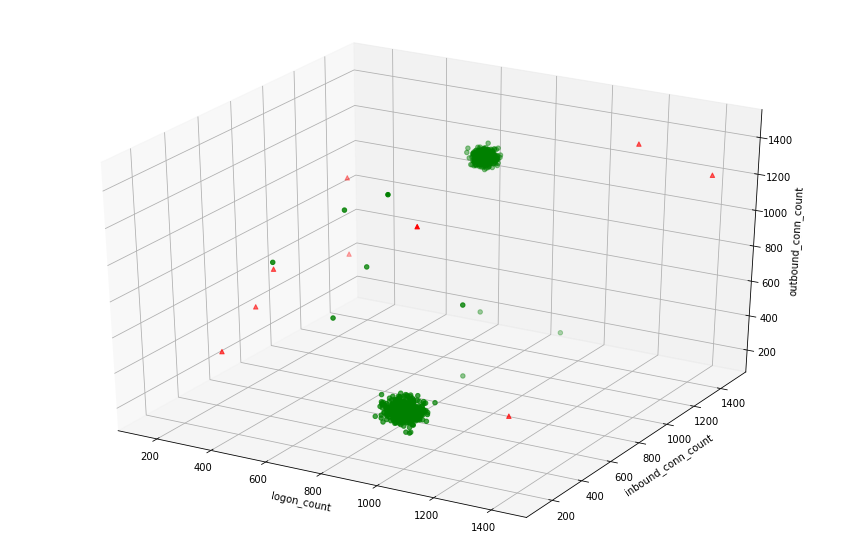

In [25]:
plt.close()

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

xs = normal_logon_count
ys = normal_inbound_conn_count
zs = normal_outbound_conn_count
ax.scatter(xs, ys, zs, c="g", marker="o")

xs = anomaly_logon_count
ys = anomaly_inbound_conn_count
zs = anomaly_outbound_conn_count
ax.scatter(xs, ys, zs, c="r", marker="^")

ax.set_xlabel('logon_count')
ax.set_ylabel('inbound_conn_count')
ax.set_zlabel('outbound_conn_count')

plt.show()
plt.close()

# interactive 3d visualization

In [26]:
normal = go.Scatter3d(
    x=normal_logon_count,
    y=normal_inbound_conn_count,
    z=normal_outbound_conn_count,
    mode='markers',
    marker=dict(
        color='rgb(200, 200, 200)',
        size=8,
        line=dict(
            color='rgb(217, 217, 217)',
            width=0.5
        ),
        opacity=0
    ),
    name="normal"
)

anomaly = go.Scatter3d(
    x=anomaly_logon_count,
    y=anomaly_inbound_conn_count,
    z=anomaly_outbound_conn_count,
    mode='markers',
    marker=dict(
        color='rgb(255, 0, 0)',
        size=8,
        line=dict(
            color='rgb(217, 0, 0)',
            width=0.5
        ),
        opacity=0
    ),
    name="anomaly"
)

data = [normal,anomaly]

layout = go.Layout(
    title='Sklearn OneClassSVM',
    scene = dict(
        xaxis = dict(
            title='logon_count'),
        yaxis = dict(
            title='in_conn_count'),
        zaxis = dict(
            title='out_conn_count'),),
    autosize=False,
    width=1000,
    height=700,
                  )
fig = go.Figure(data=data, layout=layout)
iplot(figure_or_data=fig)